# Modelos_NaiveBayes_LDA

In [261]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
from sklearn.model_selection import cross_validate , StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, make_scorer , confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, f1_score, average_precision_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler




In [262]:
current_dir = os.getcwd() # Obtener la ruta del directorio actual del notebook
ROOT_PATH = os.path.dirname(current_dir) # Obtener la ruta del directorio superior
sys.path.insert(1, ROOT_PATH) # Insertar la ruta en sys.path

import root # Importar el módulo root

## Modelos info users

In [263]:
file_path = root.DIR_DATA_STAGE + 'train_infousers.csv'

In [264]:
df_infousers = pd.read_csv(file_path)
df_infousers.head()

,PLAZO,CAPITAL,DÍAS MORA,INGRESOS MENSUALES,GASTOS MENSUALES,NUM.CREDITOS SOLICITADOS,latitud,longitud,meses_transcurridos,mes_de_pago,TIPO EMPLEO_independiente,TIPO DE VIVIENDA_propia,ESTADO CIVIL_soltero/a,ESTADO CIVIL_union libre,NIVEL EDUCATIVO_postgrado,NIVEL EDUCATIVO_profesional,NIVEL EDUCATIVO_secundaria,NIVEL EDUCATIVO_tecnico,Cuotas en mora
0,30.0,0.25,1445.0,3.000000,1.0,1.0,6.17591,-75.59174,31.077530,4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
1,30.0,0.12,905.0,1.380000,0.7,1.0,4.60971,-74.08175,35.873850,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,30.0,0.30,2284.0,1.649434,0.6,1.0,4.60971,-74.08175,12.000000,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
3,30.0,0.12,1675.0,1.000000,0.6,1.0,6.25184,-75.56359,6.307490,10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
4,30.0,0.17,738.0,1.500000,0.7,1.0,8.21639,-73.24139,17.805519,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0


## Balanceo

### info usuarios

In [265]:
X = df_infousers.drop(columns=['Cuotas en mora'])
X = StandardScaler().fit_transform(X)
y = df_infousers['Cuotas en mora']

In [266]:
# Inicializar los modelos
logistic_regression = LogisticRegression(max_iter=1000)
naive_bayes = GaussianNB()
lda = LinearDiscriminantAnalysis()

In [267]:
metricas = ['accuracy', 'precision', 'recall', 'f1','roc_auc','average_precision']

In [268]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [269]:
logistic_scores = cross_validate(logistic_regression, X, y, cv=cv, scoring=metricas)
naive_bayes_scores = cross_validate(naive_bayes, X, y, cv=cv, scoring=metricas)
lda_scores = cross_validate(lda, X, y, cv=cv, scoring=metricas)

In [270]:
def print_results(model_name, scores):
    print(f"\n{model_name}")
    for metrica in metricas:
        mean_score = np.mean(scores[f'test_{metrica}'])
        std_score = np.std(scores[f'test_{metrica}'])
        print(f"{metrica.capitalize()}: {mean_score:.2f} +/- {std_score * 2:.2f}")

print_results("Regresión Logística", logistic_scores)
print_results("Naive Bayes", naive_bayes_scores)
print_results("LDA", lda_scores)


Regresión Logística
Accuracy: 0.78 +/- 0.01
Precision: 0.80 +/- 0.01
Recall: 0.87 +/- 0.03
F1: 0.83 +/- 0.01
Roc_auc: 0.83 +/- 0.02
Average_precision: 0.88 +/- 0.02

Naive Bayes
Accuracy: 0.71 +/- 0.01
Precision: 0.77 +/- 0.02
Recall: 0.77 +/- 0.04
F1: 0.77 +/- 0.01
Roc_auc: 0.75 +/- 0.02
Average_precision: 0.81 +/- 0.03

LDA
Accuracy: 0.78 +/- 0.01
Precision: 0.80 +/- 0.02
Recall: 0.87 +/- 0.03
F1: 0.83 +/- 0.01
Roc_auc: 0.83 +/- 0.02
Average_precision: 0.88 +/- 0.02


In [271]:
def CV_scores(X, y, model_cv,k = 5):

    # Initialize the KFold
    kf = KFold(n_splits=k, random_state=42, shuffle=True)

    recall_vec = []
    precision_vec = []
    accuracy_vec = []
    f1_vec = []
    AP_vec = []
    AUC_vec = []
    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y.values[train_index], y.values[test_index]
        
        ros = RandomOverSampler(random_state=0)
        X_train_cv, y_train_cv = ros.fit_resample(X_train_cv, y_train_cv)

        # Fit the model
        model_cv.fit(X_train_cv, y_train_cv)

        # Make predictions
        y_pred = model_cv.predict(X_test_cv)
        
        # Calcular la precisión del modelo
        accuracy = accuracy_score(y_test_cv, y_pred)
        precision = precision_score(y_test_cv, y_pred)
        recall = recall_score(y_test_cv, y_pred)
        f1 = f1_score(y_test_cv, y_pred)
        AP = average_precision_score(y_test_cv, y_pred)
        AUC = roc_auc_score(y_test_cv, y_pred)
        
        recall_vec.append(recall)
        precision_vec.append(precision)
        accuracy_vec.append(accuracy)
        f1_vec.append(f1)
        AP_vec.append(AP)
        AUC_vec.append(AUC)
        
        
     
    recall =  np.mean(recall_vec)
    precision = np.mean(precision_vec)
    accuracy = np.mean(accuracy_vec)
    f1 = np.mean(f1_vec)
    AP = np.mean(AP_vec)
    AUC = np.mean(AUC_vec)
        
    metricas = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'PR-AUC': AP,
        'ROC-AUC': AUC,
    }
    return metricas
    

In [272]:
LR_score = CV_scores(X, y, LogisticRegression())
NB_score = CV_scores(X, y, GaussianNB())
LDA_score = CV_scores(X, y, LinearDiscriminantAnalysis())
print(LR_score)
print(NB_score)
print(LDA_score)

{'Recall': 0.776473946210157, 'Precision': 0.835645258243295, 'Accuracy': 0.7621055252304136, 'F1-score': 0.8049675697729107, 'PR-AUC': 0.7903158352789651, 'ROC-AUC': 0.7567393858021718}
{'Recall': 0.6922865594943871, 'Precision': 0.8053873061394512, 'Accuracy': 0.6983497590169018, 'F1-score': 0.7438349435301539, 'PR-AUC': 0.7514887272609335, 'ROC-AUC': 0.6996151933626842}
{'Recall': 0.778856429123419, 'Precision': 0.8301789125688146, 'Accuracy': 0.7593471377972361, 'F1-score': 0.8036770875443292, 'PR-AUC': 0.7865375826228084, 'ROC-AUC': 0.7520717929602629}


## Modelos para CredInfo

In [273]:
file_path = root.DIR_DATA_STAGE + 'train_creditinfo.csv'

In [274]:
df_credit_info = pd.read_csv(file_path)
df_credit_info.head()

,PLAZO,CAPITAL,INT CORRIENTE,FECHA DESEMBOLSO,DÍAS MORA,Cuotas en mora,NUM.CREDITOS SOLICITADOS,USUARIO RECURRENTE,mes,mora
0,30,500000,9385.000000,9/2/2021,13,0,4,1,10,1
1,30,350000,6569.500000,12/2/2020,4,0,5,1,1,1
2,30,300000,7080.000000,3/30/2023,6,1,1,0,4,1
3,30,210000,3941.700000,9/21/2022,4,0,3,1,10,1
4,29,400000,7257.733333,9/15/2022,30,0,2,1,10,1


In [275]:
df_credit_info.drop(columns=['FECHA DESEMBOLSO', 'DÍAS MORA'], inplace=True)

In [276]:
X = df_credit_info.drop(columns=['mora'])
X = StandardScaler().fit_transform(X)
y = df_credit_info['mora']

## Scores usando k startify K-fold

In [277]:
logistic_scores = cross_validate(logistic_regression, X, y, cv=cv, scoring=metricas)
naive_bayes_scores = cross_validate(naive_bayes, X, y, cv=cv, scoring=metricas)
lda_scores = cross_validate(lda, X, y, cv=cv, scoring=metricas)

In [278]:
print_results("Regresión Logística", logistic_scores)
print_results("Naive Bayes", naive_bayes_scores)
print_results("LDA", lda_scores)


Regresión Logística
Accuracy: 0.81 +/- 0.00
Precision: 0.86 +/- 0.01
Recall: 0.59 +/- 0.01
F1: 0.70 +/- 0.01
Roc_auc: 0.89 +/- 0.01
Average_precision: 0.85 +/- 0.01

Naive Bayes
Accuracy: 0.80 +/- 0.01
Precision: 0.88 +/- 0.01
Recall: 0.53 +/- 0.01
F1: 0.66 +/- 0.01
Roc_auc: 0.86 +/- 0.01
Average_precision: 0.82 +/- 0.01

LDA
Accuracy: 0.80 +/- 0.00
Precision: 0.91 +/- 0.01
Recall: 0.50 +/- 0.01
F1: 0.65 +/- 0.01
Roc_auc: 0.88 +/- 0.01
Average_precision: 0.84 +/- 0.01


### Scoring con Kfold normal , balancendo solo train_cv

In [279]:
LR_score = CV_scores(X, y, LogisticRegression())
NB_score = CV_scores(X, y, GaussianNB())
LDA_score = CV_scores(X, y, LinearDiscriminantAnalysis())
print(LR_score)
print(NB_score)
print(LDA_score)

{'Recall': 0.8086374597924604, 'Precision': 0.6977191775398289, 'Accuracy': 0.797222823679076, 'F1-score': 0.7490510936714465, 'PR-AUC': 0.6358222912732728, 'ROC-AUC': 0.799534567769408}
{'Recall': 0.5300429016185463, 'Precision': 0.8786623022501182, 'Accuracy': 0.7967127749097109, 'F1-score': 0.6612113065444956, 'PR-AUC': 0.6416361371261905, 'ROC-AUC': 0.7431340729710671}
{'Recall': 0.5285341431894084, 'Precision': 0.8866001425228204, 'Accuracy': 0.7982426807855699, 'F1-score': 0.6622618401735872, 'PR-AUC': 0.6450728246410324, 'ROC-AUC': 0.7440512741222189}


## Modelación

### Naive Bayes

In [280]:
##Función pára curva lift

def plot_lift_curve(y_true, y_proba, ax):
    # Create a dataframe with true labels and predicted probabilities
    df = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    df = df.sort_values('y_proba', ascending=False).reset_index(drop=True)
    
    # Calculate the cumulative gain for the lift curve
    df['cumulative_data_fraction'] = (np.arange(len(df)) + 1) / len(df)
    df['cumulative_positive_fraction'] = np.cumsum(df['y_true']) / df['y_true'].sum()
    
    # Plot the lift curve
    ax.plot(df['cumulative_data_fraction'], df['cumulative_positive_fraction'], label='Lift Curve')
    ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Baseline')
    ax.set_title('Lift Curve')
    ax.set_xlabel('Cumulative Data Fraction')
    ax.set_ylabel('Cumulative Positive Fraction')
    ax.legend()

In [281]:
def modelo(df,target_col,model):
    
    X = df.drop(columns=[target_col])
    X = StandardScaler().fit_transform(X)
    y = df[target_col]
    
    ros = RandomOverSampler(random_state=0)
    X, y = ros.fit_resample(X, y)
    
    model.fit(X, y)
    
    return model

In [304]:
def graficas(df, target_col, model):
    
    scaler = StandardScaler()
    X = df.drop(columns=[target_col])
    columns = X.columns
    X = scaler.fit_transform(X)
    y = df[target_col]
   
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] 
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    AP = average_precision_score(y, y_pred)
    AUC = roc_auc_score(y, y_pred)

   
    print("Accuracy: {:.3f}".format(accuracy))
    print("Precision: {:.3f}".format(precision))
    print("Recall: {:.3f}".format(recall))
    print("F1 Score: {:.3f}".format(f1))
    print("Average Precision: {:.3f}".format(AP))
    print("Area Under the ROC Curve: {:.3f}".format(AUC))
    print('------------------------------------------------------------------------------')
    #print(classification_report(y, y_pred))

    P_train_nb = model.predict(X)
    P_test_nb = model.predict(X)

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    disp = ConfusionMatrixDisplay.from_estimator(model, X, y, normalize='true', xticks_rotation='vertical', ax=axs[0])
    axs[0].set_title('Train Data')

    plot_lift_curve(y, y_proba, ax=axs[1])

    fig.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    plt.show()
    
    df = pd.DataFrame(scaler.inverse_transform(X), columns=columns)
    
    df['Estado'] = y
    df['Estado_Estimado'] = y_pred
    df['Probabilidad'] = np.round(y_proba * 100,2)
    
    return df

## Para infouser

In [308]:
file_path2 = root.DIR_DATA_STAGE + 'test_infousers.csv'
test_infousers = pd.read_csv(file_path2)

In [309]:
Modelo1 = modelo(df_infousers,'Cuotas en mora',logistic_regression)

Accuracy: 0.795
Precision: 0.858
Recall: 0.810
F1 Score: 0.833
Average Precision: 0.815
Area Under the ROC Curve: 0.790
------------------------------------------------------------------------------


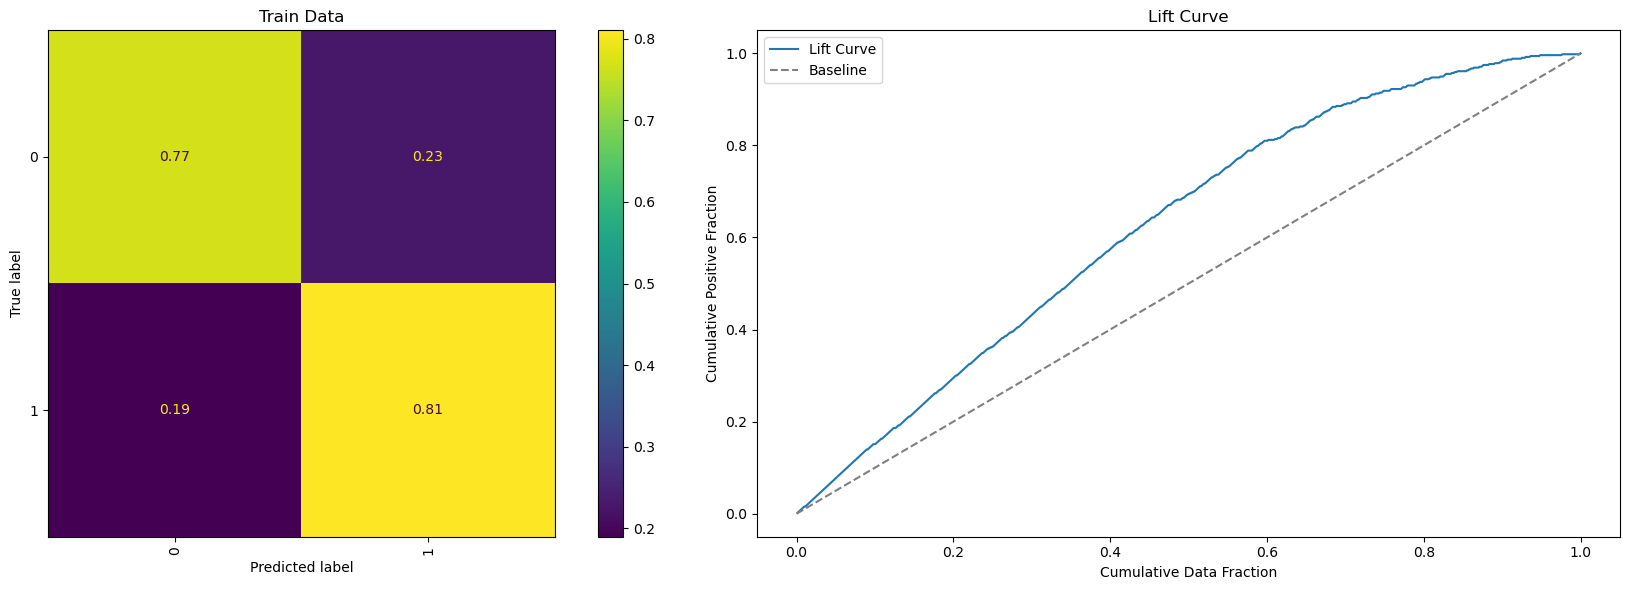

In [312]:
df_final1 = graficas (test_infousers,'Cuotas en mora', model = Modelo1)

## Para credit_info

In [317]:
file_path2 = root.DIR_DATA_STAGE + 'test_creditinfo.csv'
test_credit_info = pd.read_csv(file_path2)
test_credit_info.drop(columns=['FECHA DESEMBOLSO', 'DÍAS MORA'], inplace=True)

In [318]:
Modelo2 = modelo(df_credit_info,'mora',logistic_regression)

Accuracy: 0.793
Precision: 0.692
Recall: 0.804
F1 Score: 0.744
Average Precision: 0.630
Area Under the ROC Curve: 0.795
------------------------------------------------------------------------------


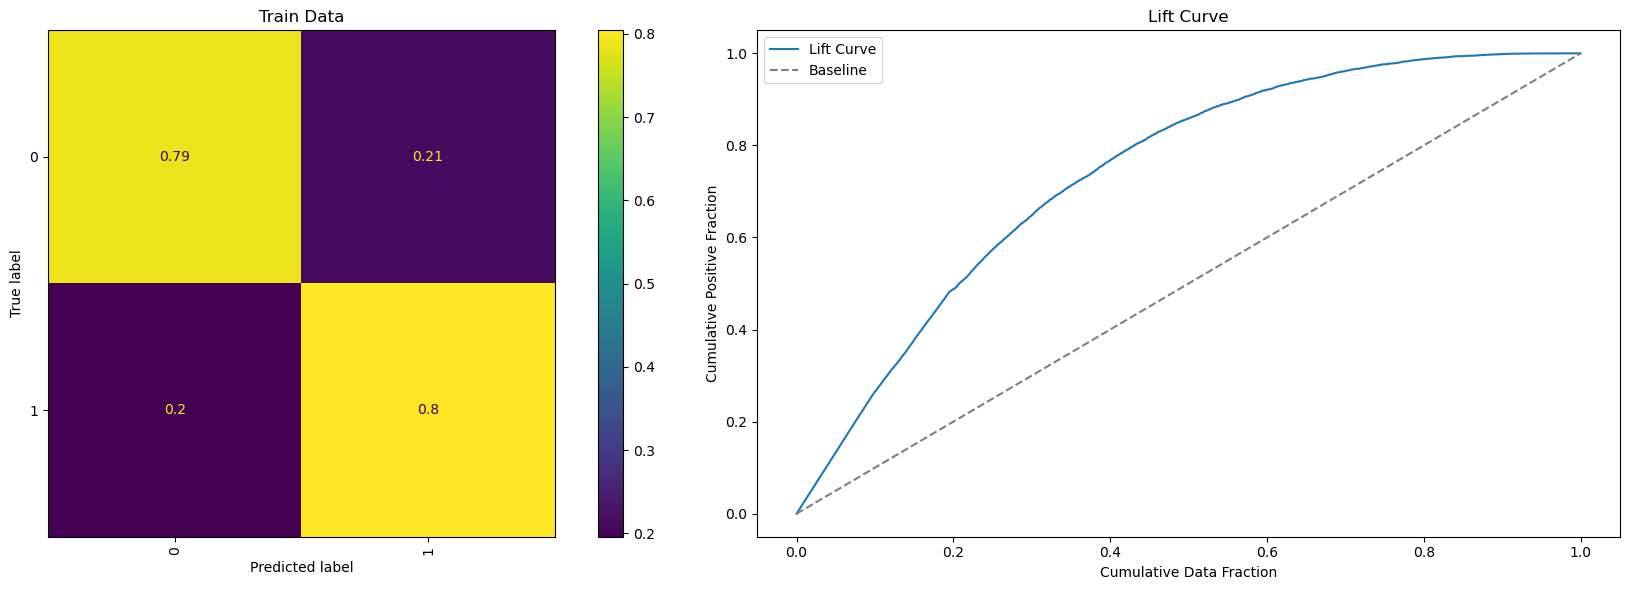

In [319]:
df_final2 = graficas (test_credit_info,'mora', model = Modelo2)

In [291]:
df_final2.head()

,PLAZO,CAPITAL,INT CORRIENTE,Cuotas en mora,NUM.CREDITOS SOLICITADOS,USUARIO RECURRENTE,mes,Estado,Estado_Estimado,Probabilidad
0,30.0,500000.0,9385.000000,0.0,4.0,1.0,10.0,1,1,54.69
1,30.0,350000.0,6569.500000,0.0,5.0,1.0,1.0,1,0,43.10
2,30.0,300000.0,7080.000000,1.0,1.0,0.0,4.0,1,1,99.23
3,30.0,210000.0,3941.700000,0.0,3.0,1.0,10.0,1,1,54.71
4,29.0,400000.0,7257.733333,0.0,2.0,1.0,10.0,1,1,65.77
